# Data Download from GDrive

In [15]:
# Step 1: Install pydrive

# !pip install pydrive

In [16]:
# url = 'https://drive.google.com/drive/u/1/folders/1SPuEOjOZIOm8mJkOqZKB7r0Bw1qgOMh5'

In [17]:
# # Step 2: Use gdown to download the folder
# import gdown


# # Convert the folder URL to a format that gdown can use
# folder_id = url.split('/')[-1]
# gdown.download_folder(f'https://drive.google.com/drive/folders/{folder_id}', quiet=False)

# Harmonization Parameters Finder

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from datetime import datetime

## Read Data

In [19]:
def read_sensor_data(csv_list):
    # csv_list = glob.glob('Lauren purpleair data\\*\\*.csv')

    csv_list
    sensor_dataframes = []

    for idx,csv_path in enumerate(csv_list):
            
        sensor_df = pd.read_csv(csv_path)
        
        if len(sensor_df.columns) < 4:
            sensor_df = pd.read_csv(csv_path,delimiter=';')
        sensor_dataframes.append(sensor_df)
    return sensor_dataframes

csv_list = glob.glob('Lauren purpleair data\\*\\*.csv')
sensor_dataframes = read_sensor_data(csv_list) #[:10]

## Clean Data

In [20]:
def create_units_dict(df):
    units_dict = {}
    for column in df.columns:
        units_dict[column] = df.loc[0, column]
    return units_dict

units_dict = create_units_dict(sensor_dataframes[0])

In [21]:
def clean_sensor_dataframes(sensor_dataframes):

    numeric_columns = ['pm2.5_atm_b', 'pm2.5_cf_1', 'pm2.5_cf_1_a', 'pm2.5_cf_1_b',	'pm10.0_atm', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1', 'pm10.0_cf_1_a', 'pm10.0_cf_1_b']
    
    
    cleaned_dataframes = []
    for idx,sensor_df in enumerate(sensor_dataframes):
        # remove header
        sensor_df = sensor_df.iloc[1:]
        # Sort by 'Timestamp'
        try:
            sensor_df = sensor_df.sort_values(by=['time_stamp']).reset_index()
        except:
            print(idx)
            display(sensor_df)
            break
        # Change 'Timestamp' to date format
        sensor_df['time_stamp'] = pd.to_datetime(sensor_df['time_stamp'])



        # Filter rows based on timestamp
        # sensor_df = sensor_df[sensor_df['time_stamp'] <= '2024-02-10']

        # Convert the 'time_stamp' column to datetime
        sensor_df['time_stamp'] = pd.to_datetime(sensor_df['time_stamp']).dt.date
        # Perform the comparison using datetime
        comparison_date = datetime(2024, 2, 10).date()
        sensor_df = sensor_df[sensor_df['time_stamp'] <= comparison_date]
        
        try:
            sensor_df = sensor_df.sort_values(by=['time_stamp']).reset_index()
        except:
            print(idx)
            print(sensor_df)
            break

            # Convert specified columns to numeric
        sensor_df[numeric_columns] = sensor_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
        # Append the cleaned DataFrame to the list
        cleaned_dataframes.append(sensor_df)
    return cleaned_dataframes

cleaned_sensor_dataframes = clean_sensor_dataframes(sensor_dataframes)

In [22]:
cleaned_sensor_dataframes[12]

,level_0,index,time_stamp,uptime,pa_latency,memory,humidity,humidity_a,humidity_b,temperature,...,pm2.5_atm_b,pm2.5_cf_1,pm2.5_cf_1_a,pm2.5_cf_1_b,pm10.0_atm,pm10.0_atm_a,pm10.0_atm_b,pm10.0_cf_1,pm10.0_cf_1_a,pm10.0_cf_1_b
0,0,1,2023-06-14,953,357,16504,24.2,24.2,NaN,85.4,...,6.906,5.772,4.638,6.906,6.319,4.896,7.742,6.319,4.896,7.742
1,90,91,2023-06-14,54953,361,17464,18.0,18.0,NaN,89.0,...,8.910,8.221,7.532,8.910,8.605,7.772,9.438,8.605,7.772,9.438
2,89,90,2023-06-14,54353,353,17464,18.0,18.0,NaN,88.8,...,8.676,8.219,7.762,8.676,8.586,7.944,9.228,8.586,7.944,9.228
3,88,89,2023-06-14,53753,351,16824,18.0,18.0,NaN,89.0,...,9.170,8.649,8.128,9.170,9.037,8.324,9.750,9.037,8.324,9.750
4,87,88,2023-06-14,53153,396,17144,18.0,18.0,NaN,89.0,...,9.298,8.691,8.084,9.298,8.906,8.262,9.550,8.906,8.262,9.550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,2714,2715,2023-07-03,1030912,367,17352,27.0,27.0,NaN,80.0,...,7.242,6.608,5.974,7.242,7.068,6.174,7.962,7.068,6.174,7.962
2736,2713,2714,2023-07-03,1030312,379,17032,27.0,27.0,NaN,80.6,...,7.532,6.614,5.696,7.532,6.942,5.784,8.100,6.942,5.784,8.100
2737,2738,2739,2023-07-03,1045312,374,17352,31.0,31.0,NaN,81.0,...,7.500,6.651,5.802,7.500,7.014,5.982,8.046,7.014,5.982,8.046
2738,2725,2726,2023-07-03,1037512,383,17325,27.0,27.0,NaN,81.0,...,5.234,4.619,4.004,5.234,4.771,4.138,5.404,4.771,4.138,5.404


In [23]:
sensor_names = [csv_path.split('\\')[1] for csv_path in csv_list] #[:10]

In [24]:
def aggregate_sensor_data(sensor_dataframes, column_name):
    # Extracting the specified column from each sensor dataframe
    cutoff_value = len(sensor_dataframes[3])
    selected_columns = [df[column_name] for df in sensor_dataframes]
    # Combining these columns into a new dataframe
    combined_df = pd.concat(selected_columns, axis=1)[:cutoff_value]
    combined_df.columns = [f'Sensor{i+1}' for i in range(len(sensor_dataframes))]
    return combined_df

### Plot

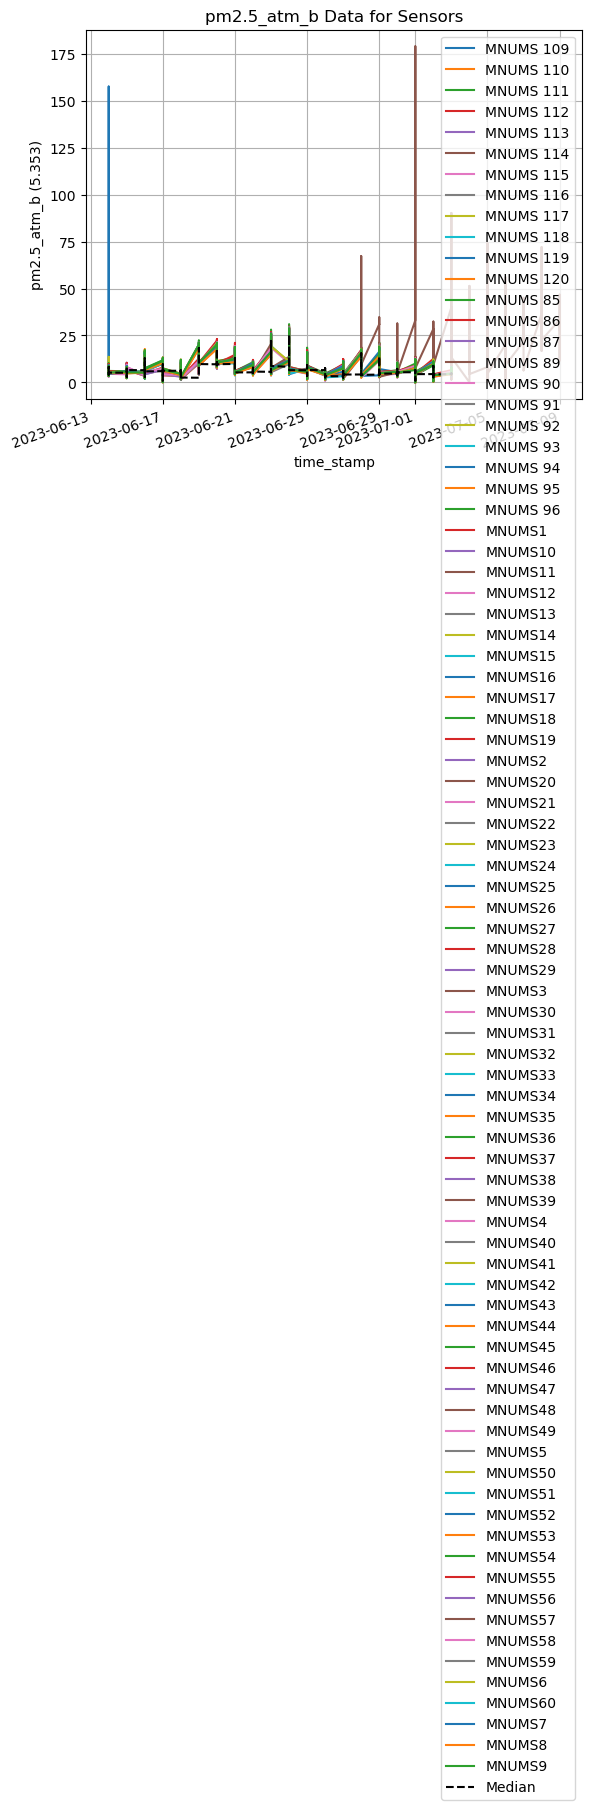

In [25]:
def plot_sensor_data(column_name, sensor_dataframes, sensor_names, units_dict, window_size=10):
    # Calculate the rolling median
    df = aggregate_sensor_data(sensor_dataframes,column_name)
    rolling_median = df.rolling(window=10, min_periods=1).median()
    for sensor_df, sensor_name in zip(sensor_dataframes, sensor_names):
        plt.plot(sensor_df['time_stamp'], sensor_df[column_name], label=sensor_name)
        
    plt.plot(sensor_dataframes[3]['time_stamp'], rolling_median.median(axis=1), color='black', linestyle='dashed', label='Median')
    plt.xlabel('time_stamp')
    plt.ylabel(f'{column_name} ({units_dict[column_name]})')
    plt.title(f'{column_name} Data for Sensors')
    plt.legend()
    plt.xticks(rotation=20, ha='right')
    plt.grid(True)
    plt.show()

plot_sensor_data('pm2.5_atm_b', cleaned_sensor_dataframes, sensor_names, units_dict, 10)

### Harmonization Parameters

In [26]:
from sklearn.linear_model import LinearRegression

# Function to fit each sensor's data to the linear function
def fit_sensor_to_median(x, y):
    lr = LinearRegression()
    lr.fit(x, y)
    return lr.coef_[0], lr.intercept_  # Return the coefficients and intercept of the linear regression model

def fit_sensor_data(column_name, sensor_dataframes, sensor_names, units_dict, window_size=10, num_dataframes=1):
    plt.figure(figsize=(10, 6))  

    cutoff_value = 1000 #len(sensor_dataframes[3]) - 100

    num_dataframes = num_dataframes
    sensor_dataframes_working = sensor_dataframes[:num_dataframes]
    sensor_names_wokring = sensor_names[:num_dataframes]

    df = aggregate_sensor_data(sensor_dataframes, column_name)
    rolling_median = df.rolling(window=window_size, min_periods=1).median()
    fitted_data_dict = {}
    coefficients_data = []

    for sensor_df, sensor_name in zip(sensor_dataframes_working, sensor_names_wokring):
        X = sensor_df[column_name].to_frame(name=column_name)[:cutoff_value]
        Y = rolling_median.median(axis=1).to_frame('median')[:cutoff_value]
        coefficients, intercept = fit_sensor_to_median(X, Y)
        fitted_data = X * coefficients + intercept
        fitted_data = fitted_data.values.flatten()
        fitted_data_dict[sensor_name] = fitted_data
        
        # Append coefficients and intercept to list
        coefficients_data.append({
            'Sensor': sensor_name,
            'Coefficient': coefficients[0],
            'Intercept': intercept[0]
        })

    # Create DataFrame from the list of coefficients and intercepts
    coefficients_df = pd.DataFrame(coefficients_data)
    return coefficients_df

In [27]:
numeric_columns = ['pm2.5_atm_b', 'pm2.5_cf_1', 'pm2.5_cf_1_a', 'pm2.5_cf_1_b',	'pm10.0_atm', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1', 'pm10.0_cf_1_a', 'pm10.0_cf_1_b']

# TODO: Using 15 dataframes for now, change to len(sensor_dataframes) later

for column_name in numeric_columns:
    coefficients_df = fit_sensor_data(column_name, cleaned_sensor_dataframes, sensor_names, units_dict, window_size=1, num_dataframes= 15) #len(sensor_dataframes))
    filename = f"parameters//{column_name.lower().replace(' ', '_')}_coefficients_df.csv"
    coefficients_df.to_csv(filename, index=False)
    print(f"{filename} saved successfully.")

parameters//pm2.5_atm_b_coefficients_df.csv saved successfully.
parameters//pm2.5_cf_1_coefficients_df.csv saved successfully.
parameters//pm2.5_cf_1_a_coefficients_df.csv saved successfully.
parameters//pm2.5_cf_1_b_coefficients_df.csv saved successfully.
parameters//pm10.0_atm_coefficients_df.csv saved successfully.
parameters//pm10.0_atm_a_coefficients_df.csv saved successfully.
parameters//pm10.0_atm_b_coefficients_df.csv saved successfully.
parameters//pm10.0_cf_1_coefficients_df.csv saved successfully.
parameters//pm10.0_cf_1_a_coefficients_df.csv saved successfully.
parameters//pm10.0_cf_1_b_coefficients_df.csv saved successfully.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>